## Step1: Import ALL Library
- part from Sklearn Packgae to implement Model

In [1]:
import time, os, psutil, atexit                
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil
from sklearn.model_selection import KFold
from tqdm import tqdm

- load time cost

# MLP Model Implementation

In [2]:
process      = psutil.Process(os.getpid())       
_t0          = time.perf_counter()               
_mem0        = process.memory_info().rss         

def _report():
    dt   = time.perf_counter() - _t0            
    mem1 = process.memory_info().rss            
    print(f"\n[STATS] runtime = {dt:,.2f} s")
    print(f"[STATS] memory  = {_mem0/2**20:,.2f} → {mem1/2**20:,.2f} MB "
          f"(Δ {(mem1-_mem0)/2**20:,.2f} MB)")

## Step2: Load Model & Traning Comparision

- Activation Functions

---

<img src="md_image_material/act_functions1.png" width="500" height="600" style="float: left; margin-right: 10px;">
<img src="md_image_material/act_functions2.png" width="550" height="600" style="float: left; margin-right: 10px;">
<br style="clear: both;">

### Warmup and Cosine Decay
<img src="md_image_material/warmup.png" width="500" height="350" style="float: left; margin-right: 10px;">

Note: Found 4 Abnormal graphs : [491 923 931 955]


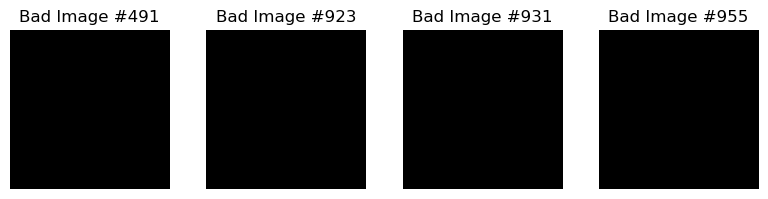

Abnormal samples have been deleted, and 1008 sheets remain



=== RELU ===
RELU     Ep002/10  Loss=3.7803
RELU     Ep004/10  Loss=2.8857
RELU     Ep006/10  Loss=1.3019
RELU     Ep008/10  Loss=0.3980
RELU     Ep010/10  Loss=1.5113


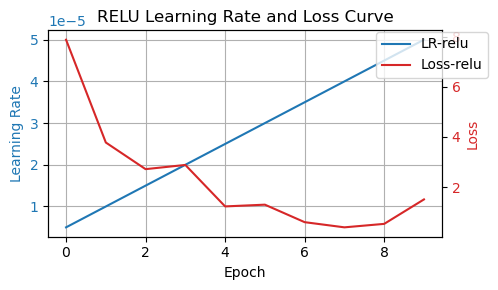


=== LEAKYRELU ===
LEAKYRELU Ep002/10  Loss=3.9035
LEAKYRELU Ep004/10  Loss=1.7812
LEAKYRELU Ep006/10  Loss=0.6394
LEAKYRELU Ep008/10  Loss=0.4365
LEAKYRELU Ep010/10  Loss=0.3768


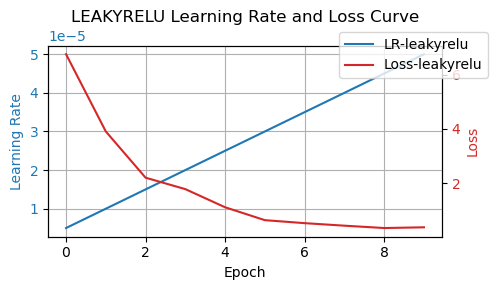


=== MISH ===
MISH     Ep002/10  Loss=4.1281
MISH     Ep004/10  Loss=2.3370
MISH     Ep006/10  Loss=0.5261
MISH     Ep008/10  Loss=2.5309
MISH     Ep010/10  Loss=1.8565


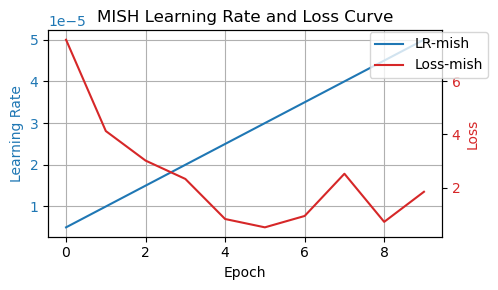

  activation train_acc test_acc
0       relu    0.9972   0.9142
1  leakyrelu    0.9957   0.9142
2       mish    0.9305   0.8383


In [3]:
NPZ_FILE      = 'image_data.npz'   # data file
CLEAN_MODE    = 'drop'             # 'drop' or 'fill'


EPOCHS        = 10
BATCH_SIZE    = 64
HID_SIZE      = 32                 # hidden layer


LR_MAX        = 1e-4               # warm-ups max LR
LR_MIN        = 1e-5               # warm-ups min LR
WARM_EPOCHS   = 20
BETAS         = (0.9, 0.999)
EPS           = 1e-8
WEIGHT_DECAY  = 1e-4               # L2 reg


MAX_GRAD_NORM = 5.0                # norm scaling
CLIP_ACT      = 10.0               # clip activation 
SOFTMAX_CAP   = 60                 # logits clip sofrmax range


OUT_DIR       = 'activation_compare_results'

warnings.filterwarnings("ignore", category=RuntimeWarning)

# load in image
def load_and_clean(path=NPZ_FILE, mode=CLEAN_MODE):
    d = np.load(path)
    X, y = d['images'].astype(np.float32), d['labels'].astype(int)
    
    mask = np.isfinite(X).all(axis=(1,2,3))
    bad  = np.where(~mask)[0]
    
    # to judge the image whether it's processed not good enough
    # it will turn into an image which is totally black one
    # with all-pixel 0 values, which is not good foe model's propagation's pass forward
    if bad.size:
        print(f"Note: Found {bad.size} Abnormal graphs : {bad[:10]}")
        
        # for i, idx in enumerate(bad[:4]):
        #     plt.figure(figsize=(2, 2))
        #     plt.imshow(X[idx].transpose(0, 1, 2), cmap='gray')
        #     plt.title(f"Bad Image #{idx}")
        #     plt.axis('off')
        #     plt.show()
        num_cols = min(4, len(bad))

        fig, axes = plt.subplots(1, num_cols, figsize=(2 * num_cols, 2))  

        for i, idx in enumerate(bad[:num_cols]):
            ax = axes[i]  
            ax.imshow(X[idx].transpose(0, 1, 2), cmap='gray')
            ax.set_title(f"Bad Image #{idx}")
            ax.axis('off')

        plt.tight_layout()  
        plt.show()
        
        # directly drop the 'abnormal' image
        # this is the way we choose to deal with the incorrectly processed images => direct delection
        if mode == 'drop':
            X, y = X[mask], y[mask]
            print(f"Abnormal samples have been deleted, and {len(X)} sheets remain")
        else:                        # fill
            for c in range(X.shape[-1]):
                chan = X[..., c]
                mean_c = np.nanmean(chan[np.isfinite(chan)])
                chan[~np.isfinite(chan)] = mean_c
                X[..., c] = chan
            print("Filling with NaN/Inf")
            
    return X, y

# make sure the channles are in the correct way
# then, using 'clipping' function to make sure the images value (input_X) are in the save range (before the normalization / standarzation)
def safe_channel_std(X):
    # (N,C,H,W) → (N,H,W,C)
    if X.shape[1] in (1,3,4) and X.shape[-1] not in (1,3,4):
        X = np.moveaxis(X, 1, -1)
    μ  = X.mean(axis=(0,1,2), keepdims=True)
    σ  = X.std (axis=(0,1,2), keepdims=True)
    σ[σ < 1e-6] = 1.0
    Xn = np.clip((X - μ) / σ, -3.0, 3.0)
    return Xn.reshape(len(Xn), -1)

# one-hot encoding 
def one_hot(y):
    o = np.zeros((len(y), 2), np.float32)
    o[np.arange(len(y)), y] = 1.0
    return o

# activation function
# with its gradient
def relu(x):        return np.maximum(0, x)
def relu_g(x):      return (x > 0).astype(x.dtype)

def leaky(x,a=0.01):return np.where(x > 0, x, a*x)
def leaky_g(x,a=0.01):return np.where(x > 0, 1.0, a).astype(x.dtype)

def softplus(x):    return np.where(x > 20, x, np.log1p(np.exp(-np.abs(x)))+np.maximum(x,0))
def sigmoid(x):
    pos=x>=0; out=np.empty_like(x)
    out[pos]  = 1/(1+np.exp(-x[pos]))
    expx      = np.exp(x[~pos])
    out[~pos] = expx/(1+expx); return out
def mish(x): return x*np.tanh(softplus(x))
def mish_g(x):
    sp=softplus(x); t=np.tanh(sp)
    return t+x*sigmoid(x)*(1-t**2)

ACTS = {
    'relu':      (relu,      relu_g),
    'leakyrelu': (lambda x: leaky(x,0.01), lambda x: leaky_g(x,0.01)),
    'mish':      (mish,      mish_g)
}

def safe_softmax(z):
    z = np.clip(z, -SOFTMAX_CAP, SOFTMAX_CAP)
    z -= z.max(axis=1, keepdims=True)
    e  = np.exp(z)
    s  = e.sum(axis=1, keepdims=True)
    s[s < 1e-20] = 1.0
    return np.clip(e/s, 1e-12, 1.0)

def cross_entropy(y, p): return -(y*np.log(p)).sum()/len(y)
def clip_grad(g):
    n = np.linalg.norm(g)
    return g if n <= MAX_GRAD_NORM else g * (MAX_GRAD_NORM/(n+1e-8))
add_bias = lambda m: np.hstack([np.ones((len(m),1), m.dtype), m])

def train_once(Xtr, ytr, Xte, yte, act):
    f, df = ACTS[act]
    in_dim = Xtr.shape[1]
    θ1 = np.random.randn(HID_SIZE, in_dim+1).astype(np.float32) * np.sqrt(2/in_dim)
    θ2 = np.random.randn(2, HID_SIZE+1).astype(np.float32) * np.sqrt(2/HID_SIZE)
    m1 = np.zeros_like(θ1); v1 = np.zeros_like(θ1)
    m2 = np.zeros_like(θ2); v2 = np.zeros_like(θ2)
    β1, β2 = BETAS
    step = 0; losses = []; rng = np.random.default_rng()
    
    lr_history = []

    # Training loop with progress bar
    for ep in range(EPOCHS):
        # Adjust learning rate using warm-up and cosine decay
        # LR Changable
        lr = LR_MAX * (ep + 1) / WARM_EPOCHS if ep < WARM_EPOCHS else (
              LR_MIN + (LR_MAX - LR_MIN) * 0.5 * (1 + math.cos(math.pi * (ep - WARM_EPOCHS) / (EPOCHS - WARM_EPOCHS))))
        
        lr_history.append(lr)

        perm = rng.permutation(len(Xtr))  # Shuffle data
        ep_loss = 0

        # Initialize progress bar for each epoch
        # pbar = tqdm(total=len(Xtr) // BATCH_SIZE, desc=f'Epoch {ep + 1}/{EPOCHS}', ncols=100)

        # Inner batch loop
        for st in range(0, len(Xtr), BATCH_SIZE):
            step += 1
            xb, yb = Xtr[perm[st:st + BATCH_SIZE]], ytr[perm[st:st + BATCH_SIZE]]
            a1 = add_bias(xb)
            z2 = a1 @ θ1.T
            h = np.clip(f(z2), -CLIP_ACT, CLIP_ACT)
            a2 = add_bias(h)
            p = safe_softmax(a2 @ θ2.T)
            ep_loss += cross_entropy(yb, p)

            d3 = p - yb
            d2 = (d3 @ θ2[:, 1:]) * df(z2)

            g2 = clip_grad((d3.T @ a2) / BATCH_SIZE) + WEIGHT_DECAY * θ2
            g1 = clip_grad((d2.T @ a1) / BATCH_SIZE) + WEIGHT_DECAY * θ1

            # AdamW updates
            for g, m, v, θ in [(g1, m1, v1, θ1), (g2, m2, v2, θ2)]:
                m[:] = β1 * m + (1 - β1) * g
                v[:] = β2 * v + (1 - β2) * (g * g)
                mh = m / (1 - β1 ** step)
                vh = v / (1 - β2 ** step)
                θ -= lr * mh / (np.sqrt(vh) + EPS)

            # pbar.update(1)  # Update progress bar for each batch

        # pbar.close()  # Close the progress bar after each epoch

        losses.append(ep_loss)
        
        # Print the loss every 10 epochs
        if (ep + 1) % 2 == 0:
            print(f'{act.upper():8} Ep{ep + 1:03d}/{EPOCHS}  Loss={ep_loss:.4f}')

    # Define prediction function
    predict = lambda X: np.argmax(add_bias(f(add_bias(X) @ θ1.T)) @ θ2.T, 1)
    tr_acc = (predict(Xtr) == np.argmax(ytr, 1)).mean()
    te_acc = (predict(Xte) == np.argmax(yte, 1)).mean()

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot Learning Rate
    ax1.plot(range(EPOCHS), lr_history, label=f'LR-{act}', color='tab:blue')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Learning Rate', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create second y-axis for Loss
    ax2 = ax1.twinx()  
    ax2.plot(losses, label=f'Loss-{act}', color='tab:red')
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Adding titles and legends
    ax1.set_title(f'{act.upper()} Learning Rate and Loss Curve')
    ax1.grid(True)

    fig.tight_layout()
    fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
    plt.savefig(os.path.join(OUT_DIR, f'lr_loss_curve_{act}.png'))
    plt.show()

    return losses, tr_acc, te_acc

def main():
    os.makedirs(OUT_DIR, exist_ok=True)
    X_raw, y = load_and_clean()
    X_flat   = safe_channel_std(X_raw)

    # train/test split
    rng = np.random.default_rng(42)
    idx = rng.permutation(len(X_flat)); cut=int(0.7*len(idx))
    Xtr,Xte = X_flat[idx[:cut]], X_flat[idx[cut:]]
    ytr,yte = y[idx[:cut]],     y[idx[cut:]]
    ytr, yte = one_hot(ytr), one_hot(yte)

    summary=[]
    print('\n')
    
    for act in ACTS:
        print(f'\n=== {act.upper()} ===')
        curve, acc_tr, acc_te = train_once(Xtr,ytr,Xte,yte, act)
        plt.figure(); plt.plot(curve); plt.title(f'Loss-{act}'); plt.xlabel('Epoch'); plt.grid(True)
        plt.savefig(os.path.join(OUT_DIR, f'loss_{act}.png')); plt.close()
        summary.append([act,f'{acc_tr:.4f}',f'{acc_te:.4f}'])

    pd.DataFrame(summary, columns=['activation','train_acc','test_acc'])\
        .to_csv(os.path.join(OUT_DIR,'metrics.csv'), index=False)
    # print("\n✓ 结果保存在", OUT_DIR)
    print(pd.DataFrame(summary,columns=['activation','train_acc','test_acc']))

if __name__ == '__main__':
    main()

## Step3: Model Cross Validation

Note: Found 4 Abnormal graphs : [491 923 931 955]


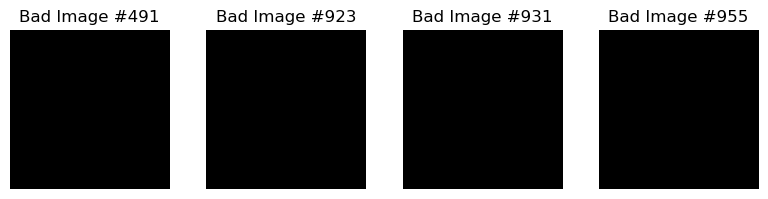

Abnormal samples have been deleted, and 1008 sheets remain

=== RELU ===

Fold 1/5
RELU     Ep002/10  Loss=4.5661
RELU     Ep004/10  Loss=1.4419
RELU     Ep006/10  Loss=0.9339
RELU     Ep008/10  Loss=0.8717
RELU     Ep010/10  Loss=0.7133


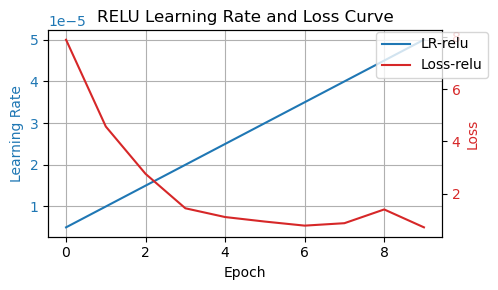


Fold 2/5
RELU     Ep002/10  Loss=5.4073
RELU     Ep004/10  Loss=2.1892
RELU     Ep006/10  Loss=0.9414
RELU     Ep008/10  Loss=1.0577
RELU     Ep010/10  Loss=0.5005


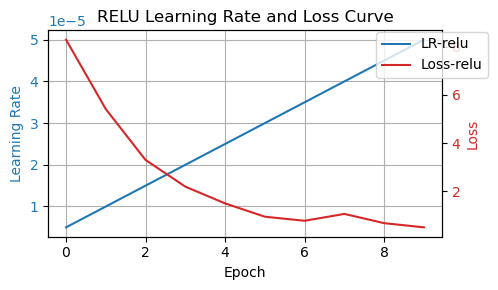


Fold 3/5
RELU     Ep002/10  Loss=4.9700
RELU     Ep004/10  Loss=1.9747
RELU     Ep006/10  Loss=0.6353
RELU     Ep008/10  Loss=0.5944
RELU     Ep010/10  Loss=0.4866


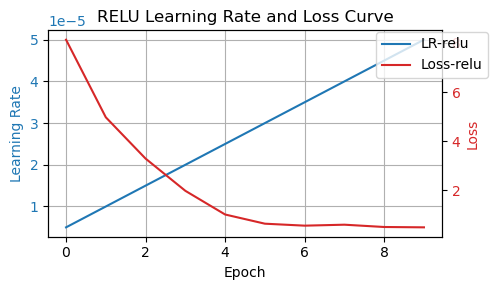


Fold 4/5
RELU     Ep002/10  Loss=5.0668
RELU     Ep004/10  Loss=3.0474
RELU     Ep006/10  Loss=1.0021
RELU     Ep008/10  Loss=0.6798
RELU     Ep010/10  Loss=1.7156


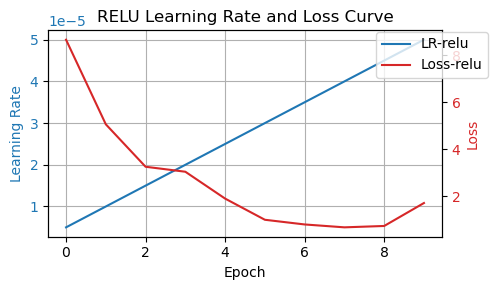


Fold 5/5
RELU     Ep002/10  Loss=5.2036
RELU     Ep004/10  Loss=1.9240
RELU     Ep006/10  Loss=0.8815
RELU     Ep008/10  Loss=0.8404
RELU     Ep010/10  Loss=0.2912


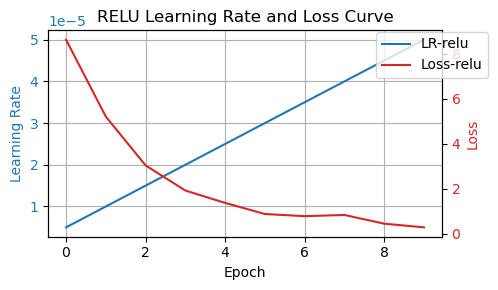


Average Train Accuracy: 92.0183%
Average Test Accuracy: 87.6839%


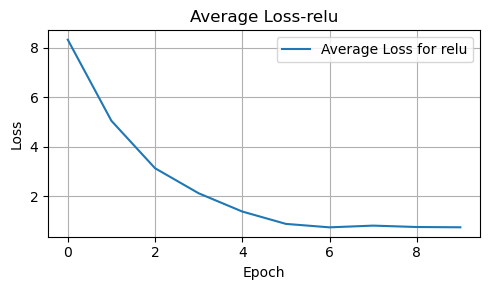


=== LEAKYRELU ===

Fold 1/5
LEAKYRELU Ep002/10  Loss=5.2386
LEAKYRELU Ep004/10  Loss=1.9578
LEAKYRELU Ep006/10  Loss=0.8162
LEAKYRELU Ep008/10  Loss=0.7617
LEAKYRELU Ep010/10  Loss=0.7560


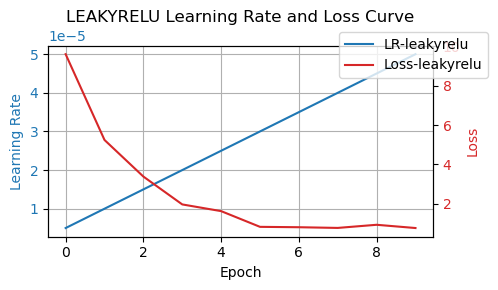


Fold 2/5
LEAKYRELU Ep002/10  Loss=4.8265
LEAKYRELU Ep004/10  Loss=1.6410
LEAKYRELU Ep006/10  Loss=0.7228
LEAKYRELU Ep008/10  Loss=0.3324
LEAKYRELU Ep010/10  Loss=0.6528


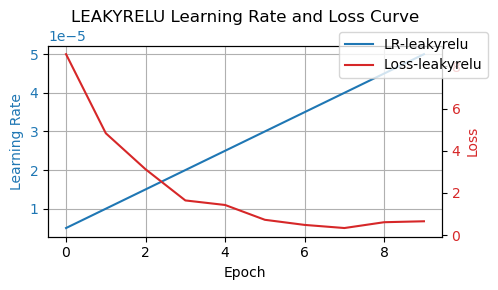


Fold 3/5
LEAKYRELU Ep002/10  Loss=4.8865
LEAKYRELU Ep004/10  Loss=1.5401
LEAKYRELU Ep006/10  Loss=0.9356
LEAKYRELU Ep008/10  Loss=0.4338
LEAKYRELU Ep010/10  Loss=0.6991


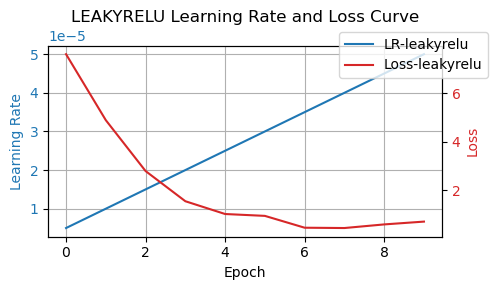


Fold 4/5
LEAKYRELU Ep002/10  Loss=4.2573
LEAKYRELU Ep004/10  Loss=1.6331
LEAKYRELU Ep006/10  Loss=0.5495
LEAKYRELU Ep008/10  Loss=0.2500
LEAKYRELU Ep010/10  Loss=1.1434


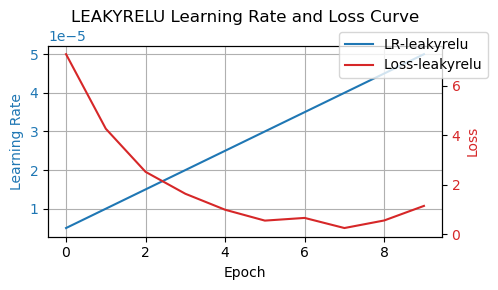


Fold 5/5
LEAKYRELU Ep002/10  Loss=5.0639
LEAKYRELU Ep004/10  Loss=1.8842
LEAKYRELU Ep006/10  Loss=1.0410
LEAKYRELU Ep008/10  Loss=1.0358
LEAKYRELU Ep010/10  Loss=1.2161


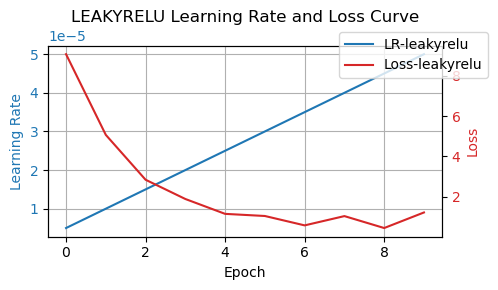


Average Train Accuracy: 98.7595%
Average Test Accuracy: 92.8590%


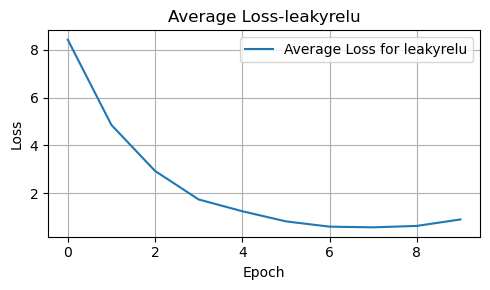


=== MISH ===

Fold 1/5
MISH     Ep002/10  Loss=5.4977
MISH     Ep004/10  Loss=1.8356
MISH     Ep006/10  Loss=0.8803
MISH     Ep008/10  Loss=0.8834
MISH     Ep010/10  Loss=1.1265


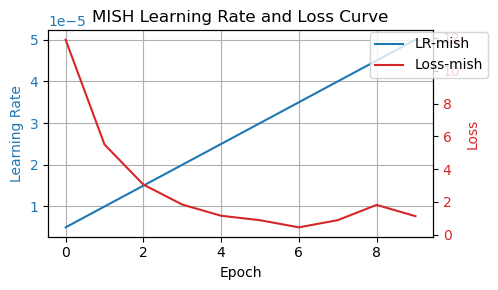


Fold 2/5
MISH     Ep002/10  Loss=5.2126
MISH     Ep004/10  Loss=2.6675
MISH     Ep006/10  Loss=1.0446
MISH     Ep008/10  Loss=0.6392
MISH     Ep010/10  Loss=0.4892


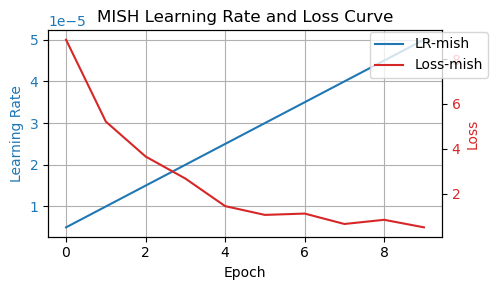


Fold 3/5
MISH     Ep002/10  Loss=4.7694
MISH     Ep004/10  Loss=2.2698
MISH     Ep006/10  Loss=0.7022
MISH     Ep008/10  Loss=0.7625
MISH     Ep010/10  Loss=0.9157


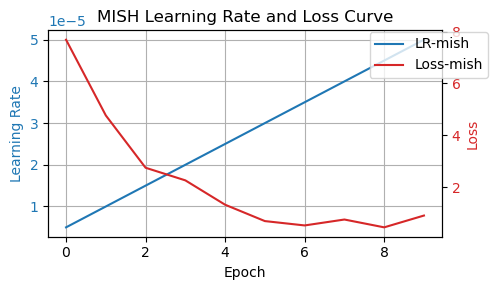


Fold 4/5
MISH     Ep002/10  Loss=5.3108
MISH     Ep004/10  Loss=1.6735
MISH     Ep006/10  Loss=0.9554
MISH     Ep008/10  Loss=1.1226
MISH     Ep010/10  Loss=0.7332


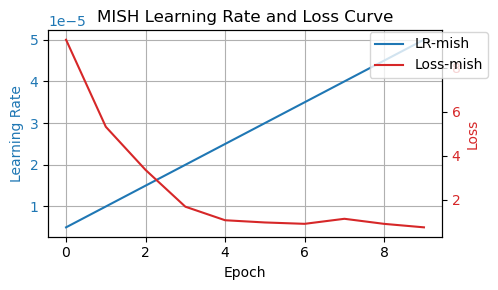


Fold 5/5
MISH     Ep002/10  Loss=4.2070
MISH     Ep004/10  Loss=1.2801
MISH     Ep006/10  Loss=0.9087
MISH     Ep008/10  Loss=0.8421
MISH     Ep010/10  Loss=0.6081


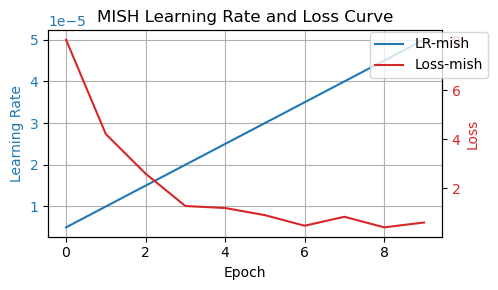


Average Train Accuracy: 98.9334%
Average Test Accuracy: 91.4709%


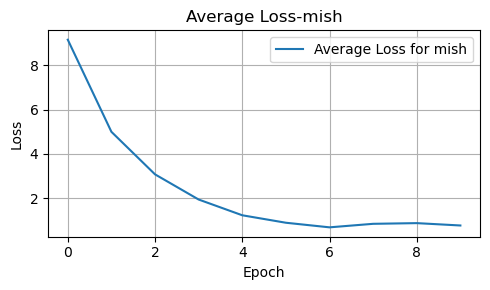


✓ Results saved in activation_compare_results
  activation train_acc test_acc
0       relu    0.9202   0.8768
1  leakyrelu    0.9876   0.9286
2       mish    0.9893   0.9147


In [4]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

def cross_validate(X, y, act, n_splits=5):
    """
    Perform K-Fold Cross Validation for the given activation function.
    
    :param X: Features
    :param y: Labels
    :param act: Activation function
    :param n_splits: Number of folds for cross-validation
    :return: Mean training and testing accuracy
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_accuracies = []
    test_accuracies = []
    losses = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Split data for this fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # One hot encoding
        y_train_one_hot = one_hot(y_train)
        y_test_one_hot = one_hot(y_test)
        
        # Train model on this fold
        loss_curve, acc_tr, acc_te = train_once(X_train, y_train_one_hot, X_test, y_test_one_hot, act)
        losses.append(loss_curve)
        train_accuracies.append(acc_tr)
        test_accuracies.append(acc_te)

    # Average the results across all folds
    avg_train_acc = np.mean(train_accuracies)
    avg_test_acc = np.mean(test_accuracies)
    
    print(f"\nAverage Train Accuracy: {avg_train_acc * 100:.4f}%")
    print(f"Average Test Accuracy: {avg_test_acc * 100:.4f}%")
    
    # Plot the loss curve across folds (average loss)
    avg_loss = np.mean(np.array(losses), axis=0)
    # plt.subplots(figsize=(5, 3))
    plt.figure(figsize=(5, 3))
    plt.plot(avg_loss)
    plt.title(f'Average Loss-{act}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend([f'Average Loss for {act}'])
    plt.tight_layout()
    
    # Show the plot instead of saving it
    plt.show()

    return avg_train_acc, avg_test_acc

def main():
    os.makedirs(OUT_DIR, exist_ok=True)
    X_raw, y = load_and_clean()
    X_flat = safe_channel_std(X_raw)

    summary = []
    for act in ACTS:
        print(f'\n=== {act.upper()} ===')
        avg_train_acc, avg_test_acc = cross_validate(X_flat, y, act)
        summary.append([act, f'{avg_train_acc:.4f}', f'{avg_test_acc:.4f}'])

    # Save the cross-validation summary to CSV
    pd.DataFrame(summary, columns=['activation', 'train_acc', 'test_acc'])\
        .to_csv(os.path.join(OUT_DIR, 'cross_validation_metrics.csv'), index=False)
    
    print("\n✓ Results saved in", OUT_DIR)
    print(pd.DataFrame(summary, columns=['activation', 'train_acc', 'test_acc']))

if __name__ == '__main__':
    main()

## Step4: Visualization Result Comparision

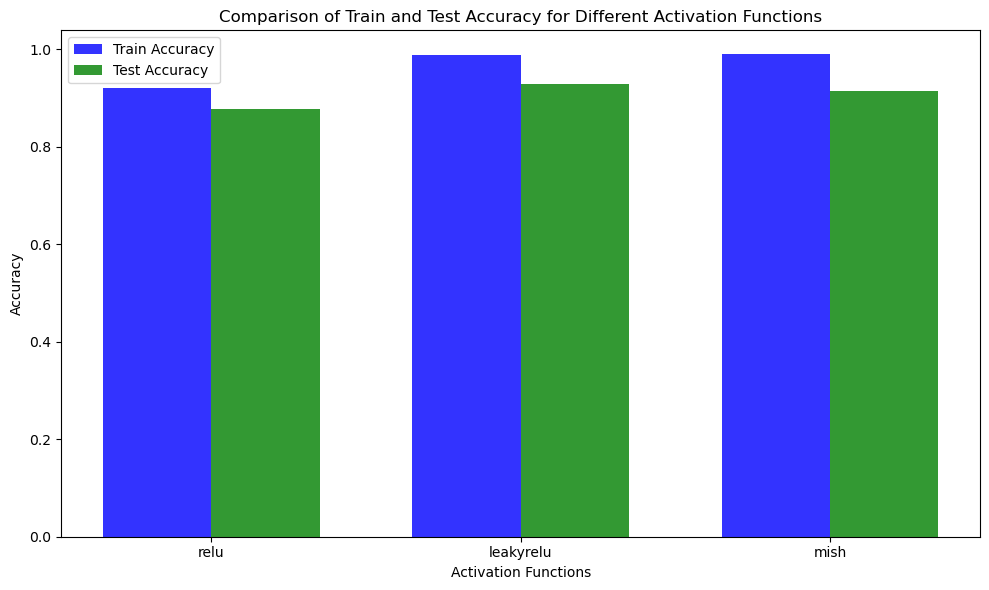

In [5]:
def visualize_results_from_csv(csv_file):
    """
    Visualizes the comparison of activation functions' training and testing accuracy from a CSV file.
    
    :param csv_file: Path to the CSV file containing the results
    """
    # Load the results from the CSV file
    df = pd.read_csv(csv_file)
    
    # Convert the 'train_acc' and 'test_acc' columns to numeric
    df['train_acc'] = pd.to_numeric(df['train_acc'])
    df['test_acc'] = pd.to_numeric(df['test_acc'])

    # Set positions for the bars
    x = range(len(df))

    # Plotting training and testing accuracy
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    opacity = 0.8

    bar1 = ax.bar(x, df['train_acc'], bar_width, alpha=opacity, color='b', label='Train Accuracy')
    bar2 = ax.bar([p + bar_width for p in x], df['test_acc'], bar_width, alpha=opacity, color='g', label='Test Accuracy')

    # Add labels, title, and ticks
    ax.set_xlabel('Activation Functions')
    ax.set_ylabel('Accuracy')
    ax.set_title('Comparison of Train and Test Accuracy for Different Activation Functions')
    ax.set_xticks([p + bar_width / 2 for p in x])
    ax.set_xticklabels(df['activation'])
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

def main():
    # Path to the saved cross-validation results CSV
    # csv_file = 'activation_compare_results/cross_validation_metrics.csv'  # Change this path 
    # if necessary
    csv_file = 'activation_compare_results/cross_validation_metrics.csv'

    # Visualize the results from the CSV file
    visualize_results_from_csv(csv_file)

if __name__ == '__main__':
    main()


## Step5: Time Cost Report

In [6]:
_report()


[STATS] runtime = 229.97 s
[STATS] memory  = 204.22 → 447.48 MB (Δ 243.27 MB)
